In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import flax
import optax
sns.set_style("darkgrid")

In [2]:
points = 10000
key = jax.random.PRNGKey(seed=42)

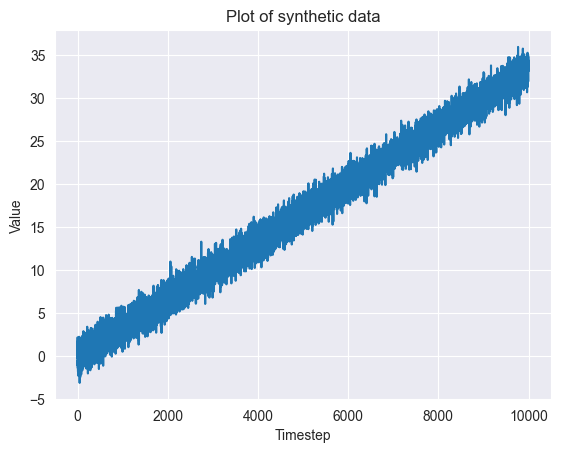

In [3]:
data = jnp.sin(jnp.arange(0, points)) * jnp.cos(jnp.arange(0, points)) + jnp.arange(0, points) * 1/300 + jax.random.normal(key=key, shape=(points,))
sns.lineplot(data)
plt.title("Plot of synthetic data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show();

In [4]:
from lstm import LSTM
from pprint import pprint

In [5]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=1, output_dim=1)


In [6]:
zero_arr = jnp.array([[0.]])

In [7]:
params.wf

Array([[-0.18471177]], dtype=float32)

In [8]:
jnp.concatenate([zero_arr, zero_arr], axis=1)

Array([[0., 0.]], dtype=float32)

In [9]:
LSTM.f_cur(params, zero_arr, zero_arr)

Array([[0.4539529]], dtype=float32)

In [10]:
LSTM.i_cur(params, zero_arr, zero_arr)

Array([[0.4539529]], dtype=float32)

In [11]:
LSTM.c_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.08290966]], dtype=float32)

In [12]:
LSTM.h_cur(params, zero_arr, zero_arr, zero_arr)

(Array([[-0.03755108]], dtype=float32), Array([[-0.08290966]], dtype=float32))

In [13]:
print(jnp.array([[0.]])[:,0])

[0.]


In [14]:
def preprocess_ts(
    x: jnp.ndarray, 
    y: jnp.ndarray,
    timestep: int
) -> tuple[jnp.ndarray, jnp.ndarray]:
    x_window = np.lib.stride_tricks.sliding_window_view(
        x, window_shape=(timestep,), axis=0
    )
    y_window = np.lib.stride_tricks.sliding_window_view(
        y, window_shape=(timestep,), axis=0
    )

    x_window = jnp.expand_dims(jnp.expand_dims(jnp.array(x_window), axis=1), axis=(3, 4))
    y_window = jnp.expand_dims(jnp.array(y_window), axis=2)
    return jnp.array(x_window), jnp.array(y_window)

In [15]:
x_window, y_window = preprocess_ts(np.arange(points).astype(np.float32), data, 5)

Each input will be a 2D array, with each 1D array inside it containing the time series for one variate.

In [16]:
x_window

Array([[[[[0.000e+00]],

         [[1.000e+00]],

         [[2.000e+00]],

         [[3.000e+00]],

         [[4.000e+00]]]],



       [[[[1.000e+00]],

         [[2.000e+00]],

         [[3.000e+00]],

         [[4.000e+00]],

         [[5.000e+00]]]],



       [[[[2.000e+00]],

         [[3.000e+00]],

         [[4.000e+00]],

         [[5.000e+00]],

         [[6.000e+00]]]],



       ...,



       [[[[9.993e+03]],

         [[9.994e+03]],

         [[9.995e+03]],

         [[9.996e+03]],

         [[9.997e+03]]]],



       [[[[9.994e+03]],

         [[9.995e+03]],

         [[9.996e+03]],

         [[9.997e+03]],

         [[9.998e+03]]]],



       [[[[9.995e+03]],

         [[9.996e+03]],

         [[9.997e+03]],

         [[9.998e+03]],

         [[9.999e+03]]]]], dtype=float32)

In [17]:
y_window

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]],

       [[-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ],
        [-1.3878875 ]],

       ...,

       [[31.921553  ],
        [34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ]],

       [[34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ]],

       [[33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ],
        [33.882206  ]]], dtype=float32)

In [18]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=100, output_dim=1)

In [19]:
from lstm import sigmoid

In [20]:
forward_full_batch = jax.vmap(LSTM.forward_full, in_axes=(None, 0))

In [21]:
x_window[0:2]

Array([[[[[0.]],

         [[1.]],

         [[2.]],

         [[3.]],

         [[4.]]]],



       [[[[1.]],

         [[2.]],

         [[3.]],

         [[4.]],

         [[5.]]]]], dtype=float32)

In [22]:
x_window[0][0]

Array([[[0.]],

       [[1.]],

       [[2.]],

       [[3.]],

       [[4.]]], dtype=float32)

In [23]:
print(x_window[0].shape)

(1, 5, 1, 1)


In [24]:
h, c = jnp.zeros(shape=(archi_params.hidden_dim, 1)), jnp.zeros(shape=(archi_params.hidden_dim, 1))
(params, h, c), o_ls = jax.lax.scan(LSTM.forward, (params, h, c), x_window[0][0])

In [25]:
mapped = jax.vmap(LSTM.forward_full, in_axes=(None, None, 0))

In [26]:
mapped(archi_params, params, x_window[0:1])

Array([[[[0.26033816]],

        [[0.6517076 ]],

        [[1.1096457 ]],

        [[1.6020582 ]],

        [[2.1130123 ]]]], dtype=float32)

In [27]:
out = LSTM.forward_batch(archi_params, params, x_window[100:110])
out

Array([[[19.815075],
        [27.53956 ],
        [30.263258],
        [31.393007],
        [31.960323]],

       [[19.92128 ],
        [27.659805],
        [30.3739  ],
        [31.495079],
        [32.056725]],

       [[20.026253],
        [27.778479],
        [30.48299 ],
        [31.595707],
        [32.151745]],

       [[20.130035],
        [27.895605],
        [30.590569],
        [31.694914],
        [32.24546 ]],

       [[20.232616],
        [28.01122 ],
        [30.696669],
        [31.79274 ],
        [32.33786 ]],

       [[20.334038],
        [28.125341],
        [30.801327],
        [31.889215],
        [32.429   ]],

       [[20.434303],
        [28.238014],
        [30.904562],
        [31.984373],
        [32.51889 ]],

       [[20.53343 ],
        [28.34926 ],
        [31.006401],
        [32.07823 ],
        [32.60758 ]],

       [[20.631435],
        [28.459099],
        [31.106886],
        [32.170803],
        [32.69507 ]],

       [[20.728336],
        [28.5675

In [28]:
true = y_window[0:2]
true

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]]], dtype=float32)

In [29]:
num_epochs = 1
batch_size = 32
num_batches = x_window.shape[0] // batch_size
learning_rate = 1e-3

In [30]:
params.wo.shape

(100, 1)

In [31]:
y_window[0:1]

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]]], dtype=float32)

In [32]:
jnp.mean((LSTM.forward_batch(archi_params, params, x_window[0:1]) - y_window[0:1]) ** 2)

Array(3.8173134, dtype=float32)

In [33]:
LSTM.mse(archi_params, params, x_window[100:110], y_window[100:110])

Array(836.74347, dtype=float32)

In [34]:
def sigmoid(x):
    return jnp.where(x >= 0, 1./(1. + jnp.exp(-x)), jnp.exp(x)/(1. + jnp.exp(x)))

In [35]:
mse_grad = jax.jacfwd(LSTM.mse, argnums=(1,))
mse_grad(archi_params, params, x_window[100:110], y_window[100:110])[0]

LSTMParams(wf=Array([[ 2.01931473e+02],
       [ 1.02141853e+02],
       [ 1.71749619e+02],
       [ 2.97221432e+01],
       [ 7.30914841e+01],
       [ 6.20450554e+01],
       [ 8.26223679e+01],
       [ 1.05834999e+02],
       [ 3.34417191e+01],
       [ 1.84100857e+01],
       [ 2.78008026e+02],
       [ 5.99970093e+01],
       [ 2.77881439e+02],
       [ 6.51126709e+01],
       [ 1.69014404e+02],
       [ 1.06873817e+02],
       [ 1.93313980e+01],
       [ 4.13615913e+01],
       [ 3.27448120e+01],
       [ 2.00699883e+01],
       [ 3.01673164e+01],
       [ 5.21606293e+01],
       [ 1.97806381e+02],
       [ 6.60627222e+00],
       [ 1.28242416e+02],
       [ 4.00673943e+01],
       [ 2.71931335e+02],
       [ 7.04409561e+01],
       [ 1.55752239e+01],
       [ 5.21555603e-01],
       [ 8.34003525e+01],
       [ 4.77092819e+01],
       [ 5.83670120e+01],
       [ 4.19366798e+01],
       [ 3.80877190e+01],
       [ 1.63363800e+02],
       [ 1.63126770e+02],
       [ 7.09635696e+01]

In [36]:
optimiser = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=learning_rate)
)

opt_state = optimiser.init(params)

In [37]:
LSTM.mse(archi_params, params, x_window[0:10], y_window[0:10])

Array(14.920936, dtype=float32)

In [38]:
LSTM.mse(archi_params, params, x_window[6000:6001], y_window[6000:6001])

Array(408.027, dtype=float32)

In [39]:
LSTM.backward(archi_params, params, x_window[100:110], y_window[100:110])

(LSTMParams(wf=Array([[ 2.01931473e+02],
        [ 1.02141853e+02],
        [ 1.71749619e+02],
        [ 2.97221432e+01],
        [ 7.30914841e+01],
        [ 6.20450554e+01],
        [ 8.26223679e+01],
        [ 1.05834999e+02],
        [ 3.34417191e+01],
        [ 1.84100857e+01],
        [ 2.78008026e+02],
        [ 5.99970093e+01],
        [ 2.77881439e+02],
        [ 6.51126709e+01],
        [ 1.69014404e+02],
        [ 1.06873817e+02],
        [ 1.93313980e+01],
        [ 4.13615913e+01],
        [ 3.27448120e+01],
        [ 2.00699883e+01],
        [ 3.01673164e+01],
        [ 5.21606293e+01],
        [ 1.97806381e+02],
        [ 6.60627222e+00],
        [ 1.28242416e+02],
        [ 4.00673943e+01],
        [ 2.71931335e+02],
        [ 7.04409561e+01],
        [ 1.55752239e+01],
        [ 5.21555603e-01],
        [ 8.34003525e+01],
        [ 4.77092819e+01],
        [ 5.83670120e+01],
        [ 4.19366798e+01],
        [ 3.80877190e+01],
        [ 1.63363800e+02],
        [ 1.63

In [40]:
LSTM.backward(archi_params, params, x_window[6000:6001], y_window[6000:6001])

(LSTMParams(wf=Array([[7.83399845e-10],
        [0.00000000e+00],
        [1.40342666e-29],
        [5.44829633e-15],
        [0.00000000e+00],
        [4.95735872e-29],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.12045730e-16],
        [0.00000000e+00],
        [2.66789798e-14],
        [2.00286182e-28],
        [1.20876758e-15],
        [0.00000000e+00],
        [2.54266634e-08],
        [0.00000000e+00],
        [1.75226182e-01],
        [0.00000000e+00],
        [6.28802717e-17],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.41628653e-09],
        [7.45840728e-01],
        [2.28374233e-07],
        [1.67892187e-18],
        [1.20538290e-21],
        [0.00000000e+00],
        [0.00000000e+00],
        [6.27071915e+01],
        [0.00000000e+00],
        [3.78279756e-22],
        [3.60016973e-27],
        [0.00000000e+00],
        [0.00000000e+00],
        [3.80957097e-08],
        [5.66086733e-08],
        [0.00000000e+00]

In [41]:
params

LSTMParams(wf=Array([[ 4.8043523e-03],
       [ 1.5793521e-02],
       [ 1.2542889e-02],
       [-2.3941053e-03],
       [-1.0306405e-02],
       [-4.2545949e-03],
       [-7.8777727e-03],
       [ 1.5641989e-02],
       [-2.6589730e-03],
       [-1.8219745e-02],
       [ 6.5664458e-03],
       [-4.1662739e-03],
       [ 7.1008285e-03],
       [ 1.9184977e-02],
       [ 4.2070225e-03],
       [ 1.5941115e-02],
       [ 1.3981364e-03],
       [-1.4670597e-02],
       [-2.6701221e-03],
       [-1.7484507e-02],
       [-1.6441122e-02],
       [-1.2099531e-02],
       [ 4.7024740e-03],
       [ 1.1323729e-03],
       [ 3.8385363e-03],
       [-2.8868534e-03],
       [ 9.4585503e-03],
       [-1.0308233e-02],
       [-1.8913949e-02],
       [ 3.2375581e-04],
       [-6.4485371e-03],
       [-3.3557012e-03],
       [-4.0155933e-03],
       [-1.3418435e-02],
       [-1.4734800e-02],
       [ 4.1190265e-03],
       [ 4.0506367e-03],
       [-1.0172627e-02],
       [-7.8171017e-03],
       [-1.

In [42]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")

    for i in range(num_batches):
        x_batch = x_window[i * batch_size : (i + 1) * batch_size]
        y_batch = y_window[i * batch_size : (i + 1) * batch_size]

        cur_grad = LSTM.backward(archi_params, params, x_batch, y_batch)[0]
        if (jnp.any(jnp.isnan(cur_grad.wf))):
            continue
        updates, opt_state = optimiser.update(cur_grad, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        params = new_params

Epoch: 1


KeyboardInterrupt: 

In [43]:
results = LSTM.forward_batch(archi_params, params, x_window)

In [44]:
results.shape

(9996, 5, 1)

In [45]:
params

LSTMParams(wf=Array([[-8.11065605e-04],
       [ 9.35042184e-03],
       [ 5.73924044e-03],
       [-5.62192732e-03],
       [-1.62793119e-02],
       [-1.00734085e-02],
       [-1.40126590e-02],
       [ 9.17912088e-03],
       [-5.03143249e-03],
       [-2.34671831e-02],
       [-7.13695190e-05],
       [-1.00054638e-02],
       [ 3.90175031e-04],
       [ 1.31724849e-02],
       [-2.52604281e-04],
       [ 9.50144138e-03],
       [ 2.71030352e-03],
       [-2.02552658e-02],
       [-5.59828710e-03],
       [-2.27693953e-02],
       [-2.18639839e-02],
       [-1.78724285e-02],
       [-1.01874489e-03],
       [ 4.35930723e-03],
       [ 7.82575633e-04],
       [-6.94329105e-03],
       [ 2.64127436e-03],
       [-1.62768513e-02],
       [-2.40878966e-02],
       [ 3.36870109e-03],
       [-1.26346694e-02],
       [-8.27015750e-03],
       [-9.59811825e-03],
       [-1.90761276e-02],
       [-2.02806536e-02],
       [-6.29655959e-04],
       [-8.94626544e-04],
       [-1.61592104e-02]

In [46]:
results[:,-1,-1]

Array([ 1.0566941,  1.2887535,  1.5183463, ..., 31.57055  , 31.57055  ,
       31.570559 ], dtype=float32)

<Axes: >

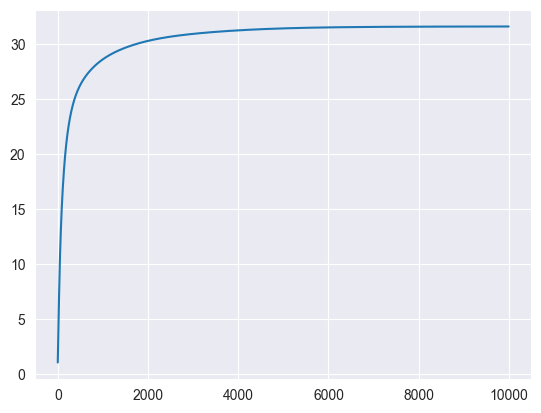

In [47]:
sns.lineplot(results[:,-1,-1])
